In [ ]:
%matplotlib inline

In [ ]:
%matplotlib qt

###############################################################################################################################################

In [ ]:
# Per-Digit Alignment Using Template Matching

import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
from PIL import Image

# Target alpha and beta values
target_alpha = 88
target_beta = 2

# Directory containing metadata files and images
data_dir = "data/full_grid"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the MLflow experiment and load the model
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')

runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# Define PSNR calculation
def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# Transform to convert PIL image to tensor in [0,1]
to_tensor = transforms.ToTensor()

# Scan metadata files
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
found_file = None

# Find matching alpha and beta
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get('idx'),
            "digit_bboxes": metadata.get('digit_bboxes'),
            "plate_number": metadata.get('plate_number')
        }
        break

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Plate Number: {found_file['plate_number']}")

# Sort bounding boxes
original_bboxes = sorted(found_file['digit_bboxes'], key=lambda bbox: bbox[0])

# Load images
original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

# Convert to NumPy
original_np = original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Align and update bounding boxes for the reconstructed image
def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        # Extract original digit
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        # Extract aligned digit
        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)

        # Compute metrics
        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

# Perform alignment
psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

# Visualization
reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
original_image_cv = cv2.imread(original_image_path)

# Draw original bounding boxes
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

# Prepare table
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title('Reconstructed Image')
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.tight_layout()
plt.show()


###############################################################################################################################################

In [ ]:
# Best PSNR Selection with Template Matching

import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import mlflow
import mlflow.pytorch
import sys
import cv2
from pytorch_msssim import ssim

# -----------------------------------
# Configuration
# -----------------------------------
data_dir = "data/full_grid"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------------
# Load Model
# -----------------------------------
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')
runs = client.search_runs(experiment_ids=experiment.experiment_id, order_by=["attributes.start_time DESC"])
run_id = runs[0].info.run_id  # Get the last run
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment {experiment.name}")

def calculate_psnr(outputs, targets):
    """Calculate PSNR between two [0,1] tensor images using PyTorch functions."""
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

to_tensor = transforms.ToTensor()

# Function to align and update bboxes using template matching per digit
def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        # Extract original digit
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window in reconstructed image
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        # Extract aligned digit
        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        # Compute metrics
        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

# -----------------------------------
# Compute PSNR Heatmap
# -----------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]

psnr_dict_avg = {}
psnr_dict_worst = {}

for meta_file in tqdm(metadata_files, desc="Processing images", unit="image"):
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)

    alpha, beta, noise_level = metadata['alpha'], metadata['beta'], metadata['noise_level']
    digit_bboxes = metadata['digit_bboxes']

    idx = metadata['idx']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    # Load images as tensors
    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed_img = model(distorted_img)
        reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

    # Convert images to NumPy
    original_np = original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    reconstructed_np = reconstructed_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Apply template matching alignment per digit
    psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes)
    avg_psnr = np.mean(psnr_per_number) if psnr_per_number else 0
    worst_psnr = min(psnr_per_number, default=0)

    if (alpha, beta) not in psnr_dict_avg:
        psnr_dict_avg[(alpha, beta)] = []
        psnr_dict_worst[(alpha, beta)] = []
    psnr_dict_avg[(alpha, beta)].append(avg_psnr)
    psnr_dict_worst[(alpha, beta)].append(worst_psnr)

# Average over multiple images if any
for key in psnr_dict_avg:
    psnr_dict_avg[key] = np.mean(psnr_dict_avg[key])
    psnr_dict_worst[key] = np.mean(psnr_dict_worst[key])

alpha_values = sorted(set(a for (a, b) in psnr_dict_avg.keys()))
beta_values = sorted(set(b for (a, b) in psnr_dict_avg.keys()))
num_alphas, num_betas = len(alpha_values), len(beta_values)

psnr_matrix_avg = np.full((num_betas, num_alphas), np.nan)
alpha_to_idx = {val: i for i, val in enumerate(alpha_values)}
beta_to_idx = {val: i for i, val in enumerate(beta_values)}

# Populate the PSNR matrix
for (a, b), val in psnr_dict_avg.items():
    psnr_matrix_avg[beta_to_idx[b], alpha_to_idx[a]] = val



In [ ]:
# Show image details for a given alpha,beta function

# -----------------------------------
# Function to show image details for a given alpha,beta
# Using the same template matching approach inside show_image_details_for
# -----------------------------------
def show_image_details_for(alpha, beta, data_dir, model, device):
    metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
    found_file = None
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata.get('alpha') == alpha and metadata.get('beta') == beta:
            found_file = {
                "metadata_file": meta_file,
                "index": metadata.get('idx'),
                "digit_bboxes": metadata.get('digit_bboxes'),
                "plate_number": metadata.get('plate_number')
            }
            break

    if found_file is None:
        print(f"No images found for alpha={alpha}, beta={beta}.")
        return

    found_file['digit_bboxes'].sort(key=lambda bbox: bbox[0])

    idx = found_file['index']
    original_image_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_image_path = os.path.join(data_dir, f"distorted_{idx}.png")

    to_tensor = transforms.ToTensor()
    original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed_tensor = model(distorted_img)
        reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # Align and update bboxes with template matching
    def calc_psnr_ssim(original_image, reconstructed_image, digit_bboxes):
        # We'll reuse align_and_update_bboxes here to get aligned results
        psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes)
        return psnr_vals, ssim_vals, updated_bboxes

    psnr_per_number, ssim_per_number, updated_bboxes = calc_psnr_ssim(original_img, reconstructed_tensor, found_file['digit_bboxes'])

    reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
    reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
    original_image_cv = cv2.imread(original_image_path)

    for i, bbox in enumerate(found_file['digit_bboxes'], start=1):
        x, y, w, h = bbox
        cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
        cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

    for i, bbox in enumerate(updated_bboxes, start=1):
        x, y, w, h = bbox
        cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
        cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
    reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

    table_data = [["Digit", "PSNR(dB)", "SSIM"]]
    for i, (p, s) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    fig2 = plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image (Alpha={alpha}, Beta={beta})')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.imshow(reconstructed_image_rgb)
    plt.title('Reconstructed Image')
    plt.axis('off')

    table = plt.table(cellText=transposed_table_data,
                      cellLoc='center',
                      loc='center',
                      bbox=[0, -0.55, 1, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.tight_layout()
    plt.show()

# -----------------------------------
# Display Heatmap and Add Click Event
# -----------------------------------
plt.figure(figsize=(10, 8))
im = plt.imshow(psnr_matrix_avg, origin='lower', aspect='auto', cmap="viridis")
plt.title("Average PSNR per Digit")
plt.colorbar(label='PSNR (dB)')
plt.xticks(range(0, num_alphas, 5), alpha_values[::5])
plt.yticks(range(0, num_betas, 5), beta_values[::5])
plt.xlabel("Alpha (degrees)")
plt.ylabel("Beta (degrees)")

def format_coord(x, y):
    col = int(round(x))
    row = int(round(y))
    if 0 <= row < num_betas and 0 <= col < num_alphas:
        alpha = alpha_values[col]
        beta = beta_values[row]
        psnr_value = psnr_matrix_avg[row, col]
        return f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: {psnr_value:.2f} dB" if not np.isnan(psnr_value) else f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: N/A"
    return "Alpha: N/A, Beta: N/A"

plt.gca().format_coord = format_coord

def on_click(event):
    if event.inaxes == plt.gca():
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta, data_dir, model, device)

plt.gcf().canvas.mpl_connect('button_press_event', on_click)

plt.tight_layout()
plt.show()


###############################################################################################################################################

In [ ]:
# Paddle OCR with Global Template Matching and Bounding Box Alignment


import os
import json
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch
from paddleocr import PaddleOCR

# -----------------------------------------------------
# Configuration
# -----------------------------------------------------

data_dir = "data/full_grid"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize PaddleOCR (English, digits only, low confidence allowed)
ocr = PaddleOCR(
    use_angle_cls=False,  
    lang='en',
    use_space_char=False,
    drop_score=0.1,
)

# -----------------------------------------------------
# Load Model via MLflow
# -----------------------------------------------------
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()
model.to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# -----------------------------------------------------
# Locate Metadata for Given Alpha, Beta
# -----------------------------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
found_file = None
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get('idx'),
            "digit_bboxes": metadata.get('digit_bboxes'),
            "plate_number": metadata.get('plate_number')
        }
        break

if not found_file:
    print("No image found for given alpha, beta.")
    exit()

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Plate Number: {found_file['plate_number']}")

# Sort original bboxes by x to ensure left-to-right order
original_bboxes = sorted(found_file['digit_bboxes'], key=lambda bbox: bbox[0])

original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

to_tensor = transforms.ToTensor()

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()


def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    """
    Template matching to find updated bounding boxes for each digit.
    """
    from pytorch_msssim import ssim
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox

        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x = max_loc[0] + search_x1
        best_y = max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

# -----------------------------------------------------
# Run PaddleOCR on the reconstructed image
# -----------------------------------------------------
reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show_bgr = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)

ocr_results = ocr.ocr(reconstructed_show_bgr, cls=False)

# -----------------------------------------------------
# Process OCR Results:
# Filter digits only, and align them with updated_bboxes
# -----------------------------------------------------
def extract_digits_from_ocr(ocr_results):
    """
    Extracts per-character bounding boxes for digits from PaddleOCR line results.
    If a line says "3163" with one bounding box, we split horizontally.
    Returns a list of dicts: {"char": c, "bbox": (x1,y1,x2,y2)} for each digit found.
    """
    per_char_results = []

    for line in ocr_results[0]:
        box, (text, conf) = line
        if not isinstance(text, str) or text.strip() == "":
            continue
        text = text.strip()

        # Keep only digits from this text
        filtered_text = "".join([ch for ch in text if ch.isdigit()])
        if len(filtered_text) == 0:
            continue

        xs = [p[0] for p in box]
        ys = [p[1] for p in box]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)

        num_chars = len(text)
        # We'll subdivide bounding box by number of characters to approximate char positions
        # But we only consider digits. This means we must map digits back to their positions
        # in the original text.

        # Approach: for each character in text, assign a sub-box. Then only keep if it's a digit.
        width = max_x - min_x
        char_width = width / num_chars if num_chars > 0 else width

        current_x = min_x
        for i, ch in enumerate(text):
            c_x1 = int(min_x + i * char_width)
            c_x2 = int(min_x + (i+1)* char_width)
            c_y1 = int(min_y)
            c_y2 = int(max_y)

            if ch.isdigit():
                per_char_results.append({
                    "char": ch,
                    "bbox": (c_x1, c_y1, c_x2, c_y2)
                })

    return per_char_results

char_results = []
if ocr_results and len(ocr_results) > 0 and ocr_results[0] is not None:
    char_results = extract_digits_from_ocr(ocr_results)

# Sort recognized digits by x-coordinate
char_results.sort(key=lambda r: r["bbox"][0])  # sort by left x

recognized_chars = [r["char"] for r in char_results]
recognized_text = "".join(recognized_chars)

# We know we need exactly 6 digits:
plate_number = found_file['plate_number']
assert len(plate_number) == 6, "Plate number must have exactly 6 digits"

# If we have more than 6 recognized digits, take only first 6 (leftmost)
if len(recognized_chars) > 6:
    recognized_chars = recognized_chars[:6]
    char_results = char_results[:6]

# If fewer than 6 digits recognized, fill missing with '?'
if len(recognized_chars) < 6:
    missing = 6 - len(recognized_chars)
    recognized_chars.extend(['?'] * missing)

final_recognized_text = "".join(recognized_chars[:6])

# Compute accuracy:
correct_digits = sum(1 for a, b in zip(plate_number, final_recognized_text) if a == b)
accuracy = correct_digits / 6.0

print(f"\nPlate Number (GT): {plate_number}")
print(f"Recognized (final): {final_recognized_text}")
print(f"OCR Accuracy: {accuracy * 100:.2f}%")

# -----------------------------------------------------
# Visualization
# -----------------------------------------------------
# Draw original bounding boxes on original image
original_image_cv = cv2.imread(original_image_path)
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(original_image_cv, str(i), (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
reconstructed_show_bgr = reconstructed_show_bgr.copy()
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show_bgr, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.putText(reconstructed_show_bgr, str(i), (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw recognized characters on reconstructed image
for r in char_results:
    c = r["char"]
    x1, y1, x2, y2 = r["bbox"]
    cv2.rectangle(reconstructed_show_bgr, (x1,y1), (x2,y2), (0,255,0), 1)
    cv2.putText(reconstructed_show_bgr, c, (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0),1)

# Prepare table for PSNR, SSIM
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show_bgr, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image with Original BBoxes')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title(f"Reconstructed Image with Updated BBoxes and OCR Results\nRecognized: {final_recognized_text}, Accuracy: {accuracy*100:.2f}%")
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.subplots_adjust(left=0.2, bottom=0.3, top=0.9)
plt.show()


###############################################################################################################################################

[2025/05/03 13:07:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\stopc/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\stopc/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

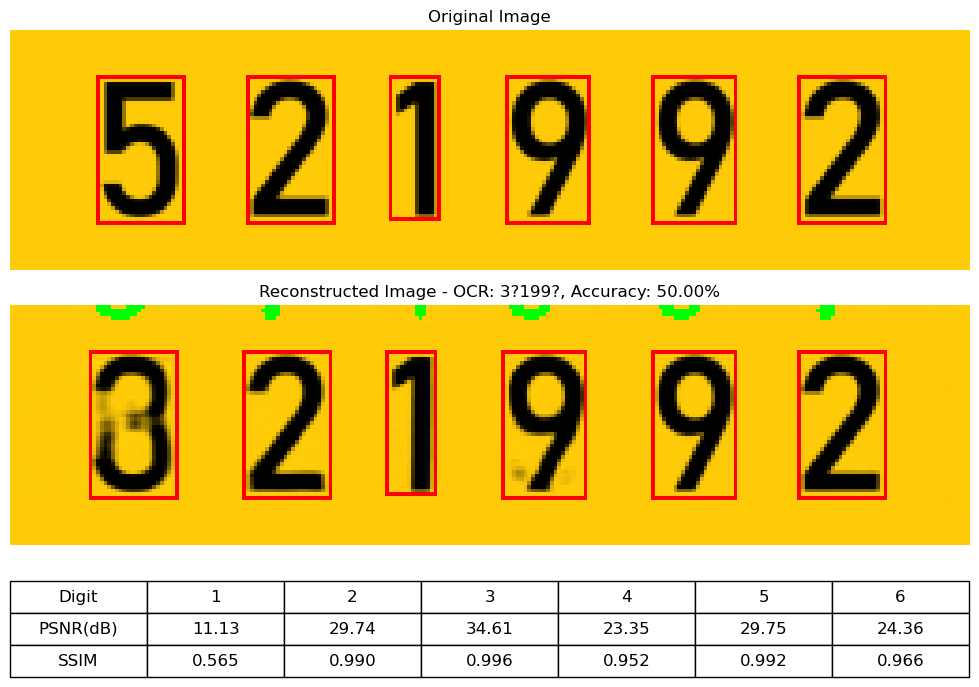

In [7]:
# Per-Digit Paddle OCR with Template Matching and Margin Adjustment

import os
import json
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from pytorch_msssim import ssim
import torch.nn.functional as F
import mlflow
import mlflow.pytorch

# --------------------
# Configuration
# --------------------

data_dir = "data/full_grid"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
search_margin = 10  # Margin for template matching search
ocr_margin = 25  # Margin around TMBB for OCR

digit_dict = "digit_dict.txt"

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en", rec_char_dict_path=digit_dict, use_space_char=False, drop_score=0)

# --------------------
# Load the Model
# --------------------
mlflow.set_experiment("Unet")
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Unet")
runs = client.search_runs(experiment_ids=experiment.experiment_id, order_by=["attributes.start_time DESC"])
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)

print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")


def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float("inf")
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()


to_tensor = transforms.ToTensor()


# --------------------
# Find Matching alpha, beta
# --------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith("metadata_") and f.endswith(".json")]
found_file = None
for meta_file in metadata_files:
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, "r") as f:
        metadata = json.load(f)
    if metadata.get("alpha") == target_alpha and metadata.get("beta") == target_beta:
        found_file = {
            "metadata_file": meta_file,
            "index": metadata.get("idx"),
            "digit_bboxes": metadata.get("digit_bboxes"),
            "plate_number": metadata.get("plate_number"),
        }
        break

if not found_file:
    print("Image with the specified alpha and beta not found.")
    exit()

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")
print(f"Plate Number: {found_file['plate_number']}")

original_bboxes = sorted(found_file["digit_bboxes"], key=lambda bbox: bbox[0])

original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

original_img = to_tensor(Image.open(original_image_path).convert("RGB")).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

original_np = original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()


def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    from pytorch_msssim import ssim

    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    for bbox in digit_bboxes:
        x, y, w, h = bbox

        original_digit = original_np[y : y + h, x : x + w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Search region
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        updated_bboxes.append((best_x, best_y, w, h))

        aligned_digit = reconstructed_np[best_y : best_y + h, best_x : best_x + w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2, 0, 1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes


psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(
    original_np, reconstructed_np, original_bboxes
)

reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
original_image_cv = cv2.imread(original_image_path)

# Draw original bounding boxes
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x + w, y + h), (0, 0, 255), 1)
    # cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show, (x, y), (x + w, y + h), (0, 0, 255), 1)
    # cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)


# --------------------
# Per-Digit OCR using TMBB and PaddleOCR
# --------------------
def run_ocr_on_digit(reconstructed_bgr, bbox, margin=5):
    x, y, w, h = bbox
    H, W, _ = reconstructed_bgr.shape
    x1 = max(0, x - margin)
    y1 = max(0, y - margin)
    x2 = min(W, x + w + margin)
    y2 = min(H, y + h + margin)

    digit_roi = reconstructed_bgr[y1:y2, x1:x2]
    if digit_roi.size == 0:
        print(f"Warning: Empty ROI for bbox {bbox}")
        return ""

    print(f"\nRunning OCR on region: x1={x1}, y1={y1}, x2={x2}, y2={y2}")

    try:
        ocr_results = ocr.ocr(digit_roi, cls=False)
        print(f"OCR Raw Results: {ocr_results}")
    except Exception as e:
        print(f"Error during OCR: {e}")
        return ""

    recognized_digit = ""
    if ocr_results and ocr_results[0]:
        for line in ocr_results[0]:
            box, text_data = line[0], line[1]
            recognized_text, confidence = text_data
            filtered = "".join(ch for ch in recognized_text if ch.isdigit())
            if filtered:
                recognized_digit = filtered[0]
                print(f"  Detected: '{recognized_digit}' (Confidence: {confidence:.2f})")
                break

    if recognized_digit:
        print(f"Final Recognized Digit: {recognized_digit}")
    else:
        print("No valid digits recognized.")
    return recognized_digit


recognized_digits = []
for i, bbox in enumerate(updated_bboxes, start=1):
    digit = run_ocr_on_digit(reconstructed_show, bbox, margin=ocr_margin)
    if not digit:
        digit = "?"  # If no digit recognized, use placeholder
    recognized_digits.append(digit)

recognized_text = "".join(recognized_digits)
ground_truth = found_file["plate_number"]
correct_digits = sum(1 for a, b in zip(ground_truth, recognized_text) if a == b)
ocr_accuracy = correct_digits / len(ground_truth) if ground_truth else 0.0

print(f"Recognized Digits (Left to Right): {recognized_text}")
print(f"OCR Accuracy: {ocr_accuracy * 100:.2f}%")

# Draw per-digit OCR results
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    digit = recognized_digits[i - 1]
    cv2.putText(reconstructed_image_rgb, digit, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# --------------------
# Visualization
# --------------------
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.imshow(original_image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title(f"Reconstructed Image - OCR: {recognized_text}, Accuracy: {ocr_accuracy*100:.2f}%")
plt.axis("off")

table = plt.table(cellText=transposed_table_data, cellLoc="center", loc="center", bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.tight_layout()
plt.show()

###############################################################################################################################################

In [4]:
target_alpha = 87  # Target alpha
target_beta = 1  # Target beta

In [ ]:
# Single Image Analysis with Metadata Retrieval and Visualization

import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.pytorch
import cv2
from pytorch_msssim import ssim
import pytesseract

# --------------------
# Configuration
# --------------------
data_dir = "data/full_grid"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MLflow model load (if needed; assuming similar to Code 1)
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")


In [ ]:
target_alpha = 87  # Target alpha
target_beta = 1  # Target beta
# --------------------
# Functions 
# --------------------

def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

def find_metadata(data_dir, target_alpha, target_beta):
    """
    Find and return metadata for the specified alpha and beta.
    """
    metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata.get('alpha') == target_alpha and metadata.get('beta') == target_beta:
            return {
                "metadata_file": meta_file,
                "index": metadata.get('idx'),
                "digit_bboxes": metadata.get('digit_bboxes'),
                "plate_number": metadata.get('plate_number')
            }
    return None

def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin =  10

    for bbox in digit_bboxes:
        x, y, w, h = bbox
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1
        updated_bboxes.append((best_x, best_y, w, h))

        # Compute PSNR and SSIM
        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2,0,1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

def ocr_single_digit(image_bgr):
    """
    Recognize a single digit using Tesseract with single char mode and digit whitelist.
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789'
    text = pytesseract.image_to_string(thresh, config=config).strip()
    if len(text) == 1 and text.isdigit():
        return text
    return '?'

def compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt, margin):
    recognized_digits = []
    for (x, y, w, h) in updated_bboxes:
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(image_bgr.shape[1], x + w + margin)
        y2 = min(image_bgr.shape[0], y + h + margin)
        
        digit_patch = image_bgr[y1:y2, x1:x2]
        recognized_digit = ocr_single_digit(digit_patch)
        recognized_digits.append(recognized_digit)

    recognized_text = "".join(recognized_digits)
    gt = plate_number_gt
    correct_digits = sum(1 for a, b in zip(gt, recognized_text) if a == b)
    ocr_accuracy = correct_digits / len(gt) if len(gt) > 0 else 0.0
    ocr_binary = 1.0 if recognized_text == gt else 0.0
    return recognized_text, ocr_accuracy, ocr_binary

# --------------------
# Main Processing
# --------------------
to_tensor = transforms.ToTensor()

# Find metadata for the target alpha and beta
found_file = find_metadata(data_dir, target_alpha, target_beta)

if not found_file:
    print("Image with the specified alpha and beta not found.")
    exit()

print(f"Found metadata file: {found_file['metadata_file']}")
print(f"Alpha: {target_alpha}, Beta: {target_beta}")

original_bboxes = found_file['digit_bboxes']

original_image_path = os.path.join(data_dir, f"original_{found_file['index']}.png")
distorted_image_path = os.path.join(data_dir, f"distorted_{found_file['index']}.png")

if not (os.path.exists(original_image_path) and os.path.exists(distorted_image_path)):
    print("Original or distorted image not found.")
    exit()

original_img = to_tensor(Image.open(original_image_path).convert('RGB')).unsqueeze(0).to(device)
distorted_img = to_tensor(Image.open(distorted_image_path).convert('RGB')).unsqueeze(0).to(device)

with torch.no_grad():
    reconstructed_tensor = model(distorted_img)
    reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, original_bboxes)

# Convert reconstructed to BGR for visualization
reconstructed_show = (reconstructed_np * 255).astype(np.uint8)
reconstructed_show = cv2.cvtColor(reconstructed_show, cv2.COLOR_RGB2BGR)
original_image_cv = cv2.imread(original_image_path)

# Draw original bounding boxes
for i, bbox in enumerate(original_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0, 0, 255), 1)
    #cv2.putText(original_image_cv, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

# Draw updated bounding boxes on reconstructed image
for i, bbox in enumerate(updated_bboxes, start=1):
    x, y, w, h = bbox
    cv2.rectangle(reconstructed_show, (x, y), (x+w, y+h), (0, 0, 255), 1)
    #cv2.putText(reconstructed_show, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)

original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)
reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

# Perform OCR and compute metrics
plate_number_gt = found_file['plate_number']
recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(reconstructed_show, updated_bboxes, plate_number_gt, margin=2)

# Prepare table data
table_data = [["Digit", "PSNR(dB)", "SSIM"]]
for i, (psnr_val, ssim_val) in enumerate(zip(psnr_per_number, ssim_per_number), start=1):
    table_data.append([str(i), f"{psnr_val:.2f}", f"{ssim_val:.3f}"])
transposed_table_data = list(zip(*table_data))

# Plotting
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_image_rgb)
plt.title(f'Reconstructed Image (alpha: {target_alpha}, beta: {target_beta})\nGT: {plate_number_gt}, Recognized: {recognized_text}, Acc: {ocr_accuracy*100:.2f}%')
plt.axis('off')

table = plt.table(cellText=transposed_table_data,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, -0.55, 1, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.tight_layout()
plt.show()



###############################################################################################################################################

In [ ]:
#Heatmap Visualization of average PSNR, SSIM, and OCR Metrics with Interactive Analysis

import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from tqdm import tqdm
import numpy as np
import mlflow
import mlflow.pytorch
import cv2
from pytorch_msssim import ssim
import pytesseract

# --------------------
# Configuration
# --------------------
data_dir = "data_test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MLflow model load
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

to_tensor = transforms.ToTensor()

def align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(reconstructed_np.shape[1], x + w + search_margin)
        search_y2 = min(reconstructed_np.shape[0], y + h + search_margin)
        search_region = reconstructed_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1
        updated_bboxes.append((best_x, best_y, w, h))

        aligned_digit = reconstructed_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2,0,1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

def ocr_single_digit(image_bgr):
    """
    Recognize a single digit using Tesseract with single char mode and digit whitelist.
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    config = r'--oem 1 --psm 10 -c tessedit_char_whitelist=0123456789'
    text = pytesseract.image_to_string(thresh, config=config).strip()
    if len(text) == 1 and text.isdigit():
        return text
    return '?'

def compute_ocr_metrics(reconstructed_bgr, updated_bboxes, plate_number_gt):
    recognized_digits = []
    M = 16
    for (x, y, w, h) in updated_bboxes:
        x1 = max(0, x - M)
        y1 = max(0, y - M)
        x2 = min(reconstructed_bgr.shape[1], x + w + M)
        y2 = min(reconstructed_bgr.shape[0], y + h + M)
        digit_patch = reconstructed_bgr[y1:y2, x1:x2]
        recognized_digit = ocr_single_digit(digit_patch)
        recognized_digits.append(recognized_digit)

    recognized_text = "".join(recognized_digits)
    gt = plate_number_gt
    correct_digits = sum(1 for a, b in zip(gt, recognized_text) if a == b)
    ocr_accuracy = correct_digits / len(gt) if len(gt) > 0 else 0.0
    ocr_binary = 1.0 if recognized_text == gt else 0.0
    return recognized_text, ocr_accuracy, ocr_binary

# -----------------------------------
# Compute metrics for each (alpha,beta)
# -----------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]

psnr_dict_avg = {}
ssim_dict_avg = {}
ocr_acc_dict_avg = {}
ocr_bin_dict_avg = {}

for meta_file in tqdm(metadata_files, desc="Processing images", unit="image"):
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)

    alpha, beta = metadata['alpha'], metadata['beta']
    digit_bboxes = metadata['digit_bboxes']
    plate_number_gt = metadata['plate_number']

    idx = metadata['idx']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    if not (os.path.exists(original_path) and os.path.exists(distorted_path)):
        continue

    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed_img = model(distorted_img)
        reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    reconstructed_np = reconstructed_img.squeeze(0).permute(1,2,0).cpu().numpy()

    psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, digit_bboxes)
    avg_psnr = np.mean(psnr_per_number) if psnr_per_number else 0.0
    avg_ssim = np.mean(ssim_per_number) if ssim_per_number else 0.0

    image_bgr = (reconstructed_np * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt)

    if (alpha, beta) not in psnr_dict_avg:
        psnr_dict_avg[(alpha, beta)] = []
        ssim_dict_avg[(alpha, beta)] = []
        ocr_acc_dict_avg[(alpha, beta)] = []
        ocr_bin_dict_avg[(alpha, beta)] = []

    psnr_dict_avg[(alpha, beta)].append(avg_psnr)
    ssim_dict_avg[(alpha, beta)].append(avg_ssim)
    ocr_acc_dict_avg[(alpha, beta)].append(ocr_accuracy)
    ocr_bin_dict_avg[(alpha, beta)].append(ocr_binary)

# Average if multiple images per angle (if any)
for key in psnr_dict_avg:
    psnr_dict_avg[key] = np.mean(psnr_dict_avg[key])
    ssim_dict_avg[key] = np.mean(ssim_dict_avg[key])
    ocr_acc_dict_avg[key] = np.mean(ocr_acc_dict_avg[key])
    ocr_bin_dict_avg[key] = np.mean(ocr_bin_dict_avg[key])

alpha_values = sorted(set(a for (a, b) in psnr_dict_avg.keys()))
beta_values = sorted(set(b for (a, b) in psnr_dict_avg.keys()))
num_alphas, num_betas = len(alpha_values), len(beta_values)

def create_matrix_from_dict(data_dict):
    mat = np.full((num_betas, num_alphas), np.nan)
    alpha_to_idx = {val: i for i, val in enumerate(alpha_values)}
    beta_to_idx = {val: i for i, val in enumerate(beta_values)}
    for (a, b), val in data_dict.items():
        mat[beta_to_idx[b], alpha_to_idx[a]] = val
    return mat

psnr_matrix_avg = create_matrix_from_dict(psnr_dict_avg)
ssim_matrix_avg = create_matrix_from_dict(ssim_dict_avg)
ocr_acc_matrix = create_matrix_from_dict(ocr_acc_dict_avg)
ocr_bin_matrix = create_matrix_from_dict(ocr_bin_dict_avg)

# -----------------------------------
# Interactive Plot with Buttons
# -----------------------------------
current_metric = 'PSNR'
fig, ax = plt.subplots(figsize=(10,8))
plt.subplots_adjust(bottom=0.2)  # space for buttons

im = ax.imshow(psnr_matrix_avg, origin='lower', aspect='auto', cmap="viridis")
ax.set_title("Average PSNR per Digit")
cb = plt.colorbar(im, ax=ax, label='PSNR (dB)')
ax.set_xticks(range(0, num_alphas, 5))
ax.set_xticklabels(alpha_values[::5])
ax.set_yticks(range(0, num_betas, 5))
ax.set_yticklabels(beta_values[::5])
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("Beta (degrees)")

def format_coord(x, y):
    col = int(round(x))
    row = int(round(y))
    if 0 <= row < num_betas and 0 <= col < num_alphas:
        alpha = alpha_values[col]
        beta = beta_values[row]
        if current_metric == 'PSNR':
            val = psnr_matrix_avg[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, PSNR: {val:.2f} dB" if not np.isnan(val) else "N/A"
        elif current_metric == 'SSIM':
            val = ssim_matrix_avg[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, SSIM: {val:.3f}" if not np.isnan(val) else "N/A"
        elif current_metric == 'OCR_Accuracy':
            val = ocr_acc_matrix[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, OCR Acc: {val*100:.2f}%" if not np.isnan(val) else "N/A"
        elif current_metric == 'OCR_Binary':
            val = ocr_bin_matrix[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, OCR Binary: {val:.0f}" if not np.isnan(val) else "N/A"
    return "N/A"

ax.format_coord = format_coord

def show_image_details_for(alpha, beta):
    # Re-run the detailed view logic
    # Find the file again
    found_file = None
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata['alpha'] == alpha and metadata['beta'] == beta:
            found_file = metadata
            break

    if found_file is None:
        print("No images found for that angle.")
        return

    found_file['digit_bboxes'].sort(key=lambda bbox: bbox[0])
    idx = found_file['idx']
    plate_number_gt = found_file['plate_number']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed_tensor = model(distorted_img)
        reconstructed_tensor = torch.clamp(reconstructed_tensor, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    reconstructed_np = reconstructed_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(original_np, reconstructed_np, found_file['digit_bboxes'])

    reconstructed_bgr = (reconstructed_np*255).astype(np.uint8)
    reconstructed_bgr = cv2.cvtColor(reconstructed_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(reconstructed_bgr, updated_bboxes, plate_number_gt)

    original_image_cv = cv2.imread(original_path)
    for i, bbox in enumerate(found_file['digit_bboxes'], start=1):
        x, y, w, h = bbox
        cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0,0,255),1)
        cv2.putText(original_image_cv, str(i), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,150,0),1)
    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)

    reconstructed_show = reconstructed_bgr.copy()
    for i,bbox in enumerate(updated_bboxes, start=1):
        x,y,w,h = bbox
        cv2.rectangle(reconstructed_show, (x,y),(x+w,y+h),(0,0,255),1)
        cv2.putText(reconstructed_show,str(i),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,150,0),1)
    reconstructed_image_rgb = cv2.cvtColor(reconstructed_show, cv2.COLOR_BGR2RGB)

    table_data = [["Digit","PSNR(dB)","SSIM"]]
    for i,(p,s) in enumerate(zip(psnr_vals, ssim_vals), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    fig2 = plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image (Alpha={alpha}, Beta={beta})')
    plt.axis('off')

    plt.subplot(2,1,2)
    plt.imshow(reconstructed_image_rgb)
    plt.title(f'Reconstructed Image\nGT: {plate_number_gt}, Rec: {recognized_text}, OCR Acc: {ocr_accuracy*100:.2f}%, Binary: {ocr_binary}')
    plt.axis('off')

    table = plt.table(cellText=transposed_table_data,
                      cellLoc='center',
                      loc='center',
                      bbox=[0,-0.55,1,0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.tight_layout()
    plt.show()

def on_click(event):
    if event.inaxes == ax:
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta)

cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Add buttons to switch between metrics
ax_psnr = plt.axes([0.1, 0.05, 0.1, 0.05])
ax_ssim = plt.axes([0.22, 0.05, 0.1, 0.05])
ax_ocr_acc = plt.axes([0.34, 0.05, 0.12, 0.05])
ax_ocr_bin = plt.axes([0.48, 0.05, 0.1, 0.05])

btn_psnr = Button(ax_psnr, 'PSNR')
btn_ssim = Button(ax_ssim, 'SSIM')
btn_ocr_acc = Button(ax_ocr_acc, 'OCR Acc')
btn_ocr_bin = Button(ax_ocr_bin, 'OCR Bin')

def update_heatmap(metric):
    global current_metric
    current_metric = metric
    ax.clear()
    if metric == 'PSNR':
        data = psnr_matrix_avg
        title = "Average PSNR per Digit"
        cbar_label = "PSNR (dB)"
    elif metric == 'SSIM':
        data = ssim_matrix_avg
        title = "Average SSIM per Digit"
        cbar_label = "SSIM"
    elif metric == 'OCR_Accuracy':
        data = ocr_acc_matrix
        title = "Average OCR Accuracy"
        cbar_label = "OCR Acc"
    else:
        data = ocr_bin_matrix
        title = "OCR Binary (1=All Correct)"
        cbar_label = "OCR Binary"

    im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(range(0,num_alphas,5))
    ax.set_xticklabels(alpha_values[::5])
    ax.set_yticks(range(0,num_betas,5))
    ax.set_yticklabels(beta_values[::5])
    ax.set_xlabel("Alpha (degrees)")
    ax.set_ylabel("Beta (degrees)")
    ax.format_coord = format_coord
    fig.colorbar(im, ax=ax, label=cbar_label)
    fig.canvas.draw_idle()

def on_psnr_clicked(event):
    update_heatmap('PSNR')

def on_ssim_clicked(event):
    update_heatmap('SSIM')

def on_ocr_acc_clicked(event):
    update_heatmap('OCR_Accuracy')

def on_ocr_bin_clicked(event):
    update_heatmap('OCR_Binary')

btn_psnr.on_clicked(on_psnr_clicked)
btn_ssim.on_clicked(on_ssim_clicked)
btn_ocr_acc.on_clicked(on_ocr_acc_clicked)
btn_ocr_bin.on_clicked(on_ocr_bin_clicked)

current_metric = 'PSNR'  # default

plt.tight_layout()
plt.show()


###############################################################################################################################################

In [ ]:
#Heatmap Visualization of worst PSNR, worst SSIM, and OCR Metrics with Interactive Analysis

import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from tqdm import tqdm
import numpy as np
import mlflow
import mlflow.pytorch
import cv2
from pytorch_msssim import ssim
import pytesseract

# --------------------
# Configuration
# --------------------
data_dir = "data/full_grid"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MLflow model load
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# --------------------
# Functions 
# --------------------

def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

def align_and_update_bboxes(original_np, generated_np, digit_bboxes):
    psnr_values = []
    ssim_values = []
    updated_bboxes = []
    search_margin = 10

    for bbox in digit_bboxes:
        x, y, w, h = bbox
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(generated_np.shape[1], x + w + search_margin)
        search_y2 = min(generated_np.shape[0], y + h + search_margin)
        search_region = generated_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1
        updated_bboxes.append((best_x, best_y, w, h))

        # Compute PSNR and SSIM
        aligned_digit = generated_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2,0,1)).unsqueeze(0).to(device)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0).to(device)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)

    return psnr_values, ssim_values, updated_bboxes

def ocr_single_digit(image_bgr):
    """
    Recognize a single digit using Tesseract with single char mode and digit whitelist.
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    config = r'--oem 1 --psm 10 -c tessedit_char_whitelist=0123456789'
    text = pytesseract.image_to_string(thresh, config=config).strip()
    if len(text) == 1 and text.isdigit():
        return text
    return '?'

def compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt, margin):
    recognized_digits = []
    for (x, y, w, h) in updated_bboxes:
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(image_bgr.shape[1], x + w + margin)
        y2 = min(image_bgr.shape[0], y + h + margin)
        
        digit_patch = image_bgr[y1:y2, x1:x2]
        recognized_digit = ocr_single_digit(digit_patch)
        recognized_digits.append(recognized_digit)

    recognized_text = "".join(recognized_digits)
    gt = plate_number_gt
    correct_digits = sum(1 for a, b in zip(gt, recognized_text) if a == b)
    ocr_accuracy = correct_digits / len(gt) if len(gt) > 0 else 0.0
    ocr_binary = 1.0 if recognized_text == gt else 0.0
    return recognized_text, ocr_accuracy, ocr_binary

# --------------------------------------
# Compute metrics for each (alpha, beta)
# --------------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]

psnr_dict_worst = {}
ssim_dict_worst = {}
ocr_acc_dict_avg = {}
ocr_bin_dict_avg = {}

to_tensor = transforms.ToTensor()

for meta_file in tqdm(metadata_files, desc="Processing images", unit="image"):
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)

    alpha, beta = metadata['alpha'], metadata['beta']
    digit_bboxes = metadata['digit_bboxes']
    plate_number_gt = metadata['plate_number']

    idx = metadata['idx']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    if not (os.path.exists(original_path) and os.path.exists(distorted_path)):
        continue

    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_img = model(distorted_img)
        generated_img = torch.clamp(generated_img, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    generated_np = generated_img.squeeze(0).permute(1,2,0).cpu().numpy()

    psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, generated_np, digit_bboxes)

    # Take the worst (minimum) PSNR and SSIM values across all digits for this image
    worst_psnr = np.min(psnr_per_number) if psnr_per_number else 0.0
    worst_ssim = np.min(ssim_per_number) if ssim_per_number else 0.0

    image_bgr = (generated_np * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt, margin = 2)

    if (alpha, beta) not in psnr_dict_worst:
        psnr_dict_worst[(alpha, beta)] = []
        ssim_dict_worst[(alpha, beta)] = []
        ocr_acc_dict_avg[(alpha, beta)] = []
        ocr_bin_dict_avg[(alpha, beta)] = []

    psnr_dict_worst[(alpha, beta)].append(worst_psnr)
    ssim_dict_worst[(alpha, beta)].append(worst_ssim)
    ocr_acc_dict_avg[(alpha, beta)].append(ocr_accuracy)
    ocr_bin_dict_avg[(alpha, beta)].append(ocr_binary)

alpha_values = sorted(set(a for (a, b) in psnr_dict_worst.keys()))
beta_values = sorted(set(b for (a, b) in psnr_dict_worst.keys()))
num_alphas, num_betas = len(alpha_values), len(beta_values)

def create_matrix_from_dict(data_dict):
    mat = np.full((num_betas, num_alphas), np.nan)
    alpha_to_idx = {val: i for i, val in enumerate(alpha_values)}
    beta_to_idx = {val: i for i, val in enumerate(beta_values)}
    for (a, b), val_list  in data_dict.items():
        val = np.min(val_list) if val_list else np.nan
        mat[beta_to_idx[b], alpha_to_idx[a]] = val
    return mat

psnr_matrix = create_matrix_from_dict(psnr_dict_worst)
ssim_matrix = create_matrix_from_dict(ssim_dict_worst)
ocr_acc_matrix = create_matrix_from_dict(ocr_acc_dict_avg)
ocr_bin_matrix = create_matrix_from_dict(ocr_bin_dict_avg)

In [ ]:
# -----------------------------------
# Interactive Plot with Buttons
# -----------------------------------
current_metric = 'PSNR'
fig, ax = plt.subplots(figsize=(10,8))
plt.subplots_adjust(bottom=0.2)  # space for buttons

im = ax.imshow(psnr_matrix, origin='lower', aspect='auto', cmap="viridis")
ax.set_title("Worst PSNR per Image (Minimum Digit PSNR)")
cb = plt.colorbar(im, ax=ax, label='PSNR (dB)')
ax.set_xticks(range(0, num_alphas, 5))
ax.set_xticklabels(alpha_values[::5])
ax.set_yticks(range(0, num_betas, 5))
ax.set_yticklabels(beta_values[::5])
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("Beta (degrees)")

def format_coord(x, y):
    col = int(round(x))
    row = int(round(y))
    if 0 <= row < num_betas and 0 <= col < num_alphas:
        alpha = alpha_values[col]
        beta = beta_values[row]
        if current_metric == 'PSNR':
            val = psnr_matrix[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, Worst PSNR: {val:.2f} dB" if not np.isnan(val) else "N/A"
        elif current_metric == 'SSIM':
            val = ssim_matrix[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, Worst SSIM: {val:.3f}" if not np.isnan(val) else "N/A"
        elif current_metric == 'OCR_Accuracy':
            val = ocr_acc_matrix[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, OCR Acc: {val*100:.2f}%" if not np.isnan(val) else "N/A"
        elif current_metric == 'OCR_Binary':
            val = ocr_bin_matrix[row, col]
            return f"Alpha: {alpha}, Beta: {beta}, OCR Binary: {val:.0f}" if not np.isnan(val) else "N/A"
    return "N/A"

ax.format_coord = format_coord

def show_image_details_for(alpha, beta):
    # Re-run the detailed view logic
    found_file = None
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata['alpha'] == alpha and metadata['beta'] == beta:
            found_file = metadata
            break

    if found_file is None:
        print("No images found for that angle.")
        return

    found_file['digit_bboxes'].sort(key=lambda bbox: bbox[0])
    idx = found_file['idx']
    plate_number_gt = found_file['plate_number']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_tensor = model(distorted_img)
        generated_tensor = torch.clamp(generated_tensor, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    generated_np = generated_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(original_np, generated_np, found_file['digit_bboxes'])

    generated_bgr = (generated_np*255).astype(np.uint8)
    generated_bgr = cv2.cvtColor(generated_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(generated_bgr, updated_bboxes, plate_number_gt, margin = 2)

    original_image_cv = cv2.imread(original_path)
    for i, bbox in enumerate(found_file['digit_bboxes'], start=1):
        x, y, w, h = bbox
        cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0,0,255),1)
        cv2.putText(original_image_cv, str(i), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,150,0),1)
    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)

    generated_show = generated_bgr.copy()
    for i,bbox in enumerate(updated_bboxes, start=1):
        x,y,w,h = bbox
        cv2.rectangle(generated_show, (x,y),(x+w,y+h),(0,0,255),1)
        cv2.putText(generated_show,str(i),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,150,0),1)
    generated_image_rgb = cv2.cvtColor(generated_show, cv2.COLOR_BGR2RGB)

    table_data = [["Digit","PSNR(dB)","SSIM"]]
    for i,(p,s) in enumerate(zip(psnr_vals, ssim_vals), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    fig2 = plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image (Alpha={alpha}, Beta={beta})')
    plt.axis('off')

    plt.subplot(2,1,2)
    plt.imshow(generated_image_rgb)
    plt.title(f'Generated Image\nGT: {plate_number_gt}, Rec: {recognized_text}, OCR Acc: {ocr_accuracy*100:.2f}%, Binary: {ocr_binary}')
    plt.axis('off')

    table = plt.table(cellText=transposed_table_data,
                      cellLoc='center',
                      loc='center',
                      bbox=[0,-0.55,1,0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.tight_layout()
    plt.show()

def on_click(event):
    if event.inaxes == ax:
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta)

cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Add buttons to switch between metrics
ax_psnr = plt.axes([0.1, 0.05, 0.1, 0.05])
ax_ssim = plt.axes([0.22, 0.05, 0.1, 0.05])
ax_ocr_acc = plt.axes([0.34, 0.05, 0.12, 0.05])
ax_ocr_bin = plt.axes([0.48, 0.05, 0.1, 0.05])

btn_psnr = Button(ax_psnr, 'PSNR')
btn_ssim = Button(ax_ssim, 'SSIM')
btn_ocr_acc = Button(ax_ocr_acc, 'OCR Acc')
btn_ocr_bin = Button(ax_ocr_bin, 'OCR Bin')

def update_heatmap(metric):
    global current_metric
    current_metric = metric
    ax.clear()
    if metric == 'PSNR':
        data = psnr_matrix
        title = "Worst PSNR per Image (Minimum Digit PSNR)"
        cbar_label = "PSNR (dB)"
    elif metric == 'SSIM':
        data = ssim_matrix
        title = "Worst SSIM per Image (Minimum Digit SSIM)"
        cbar_label = "SSIM"
    elif metric == 'OCR_Accuracy':
        data = ocr_acc_matrix
        title = "Average OCR Accuracy"
        cbar_label = "OCR Acc"
    else:
        data = ocr_bin_matrix
        title = "OCR Binary (1=All Correct)"
        cbar_label = "OCR Binary"

    im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(range(0,num_alphas,5))
    ax.set_xticklabels(alpha_values[::5])
    ax.set_yticks(range(0,num_betas,5))
    ax.set_yticklabels(beta_values[::5])
    ax.set_xlabel("Alpha (degrees)")
    ax.set_ylabel("Beta (degrees)")
    ax.format_coord = format_coord
    fig.colorbar(im, ax=ax, label=cbar_label)
    fig.canvas.draw_idle()

def on_psnr_clicked(event):
    update_heatmap('PSNR')

def on_ssim_clicked(event):
    update_heatmap('SSIM')

def on_ocr_acc_clicked(event):
    update_heatmap('OCR_Accuracy')

def on_ocr_bin_clicked(event):
    update_heatmap('OCR_Binary')

btn_psnr.on_clicked(on_psnr_clicked)
btn_ssim.on_clicked(on_ssim_clicked)
btn_ocr_acc.on_clicked(on_ocr_acc_clicked)
btn_ocr_bin.on_clicked(on_ocr_bin_clicked)

current_metric = 'PSNR'  # default

plt.tight_layout()
plt.show()

###############################################################################################################################################

In [ ]:
# #Heatmap of worst PSNR, SSIM, and OCR in parallel
import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from tqdm import tqdm
import numpy as np
import mlflow
import mlflow.pytorch
import cv2
from pytorch_msssim import ssim
import pytesseract
from joblib import Parallel, delayed

# --------------------
# Configuration
# --------------------
data_dir = "data/test"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MLflow model load
mlflow.set_experiment('Unet')
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name('Unet')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["attributes.start_time DESC"],
    max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# --------------------
# Functions 
# --------------------

def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float('inf')
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

def ocr_single_digit(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    config = r'--oem 1 --psm 10 -c tessedit_char_whitelist=0123456789'
    text = pytesseract.image_to_string(thresh, config=config).strip()
    if len(text) == 1 and text.isdigit():
        return text
    return '?'

def align_and_update_bboxes(original_np, generated_np, digit_bboxes):
    search_margin = 16

    def process_digit_bbox(bbox):
        x, y, w, h = bbox
        original_digit = original_np[y:y+h, x:x+w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(generated_np.shape[1], x + w + search_margin)
        search_y2 = min(generated_np.shape[0], y + h + search_margin)
        search_region = generated_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        # Compute PSNR and SSIM
        aligned_digit = generated_np[best_y:best_y+h, best_x:best_x+w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2,0,1)).unsqueeze(0)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2,0,1)).unsqueeze(0)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()

        return psnr_val, ssim_val, (best_x, best_y, w, h)

    results = Parallel(n_jobs=-1)(delayed(process_digit_bbox)(bbox) for bbox in digit_bboxes)
    psnr_values = [r[0] for r in results]
    ssim_values = [r[1] for r in results]
    updated_bboxes = [r[2] for r in results]

    return psnr_values, ssim_values, updated_bboxes

def compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt, margin):
    def process_bbox(bbox):
        x, y, w, h = bbox
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(image_bgr.shape[1], x + w + margin)
        y2 = min(image_bgr.shape[0], y + h + margin)
        digit_patch = image_bgr[y1:y2, x1:x2]
        recognized_digit = ocr_single_digit(digit_patch)
        return recognized_digit

    recognized_digits = Parallel(n_jobs=-1)(delayed(process_bbox)(bbox) for bbox in updated_bboxes)
    recognized_text = "".join(recognized_digits)
    gt = plate_number_gt
    correct_digits = sum(1 for a, b in zip(gt, recognized_text) if a == b)
    ocr_accuracy = correct_digits / len(gt) if len(gt) > 0 else 0.0
    ocr_binary = 1.0 if recognized_text == gt else 0.0
    return recognized_text, ocr_accuracy, ocr_binary

# --------------------------------------
# Compute metrics for each (alpha, beta)
# --------------------------------------
metadata_files = [f for f in os.listdir(data_dir) if f.startswith('metadata_') and f.endswith('.json')]

psnr_dict_worst = {}
ssim_dict_worst = {}
ocr_acc_dict_avg = {}
ocr_bin_dict_avg = {}

to_tensor = transforms.ToTensor()

for meta_file in tqdm(metadata_files, desc="Processing images", unit="image"):
    meta_path = os.path.join(data_dir, meta_file)
    with open(meta_path, 'r') as f:
        metadata = json.load(f)

    alpha, beta = metadata['alpha'], metadata['beta']
    digit_bboxes = metadata['digit_bboxes']
    plate_number_gt = metadata['plate_number']

    idx = metadata['idx']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    if not (os.path.exists(original_path) and os.path.exists(distorted_path)):
        continue

    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_img = model(distorted_img)
        generated_img = torch.clamp(generated_img, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    generated_np = generated_img.squeeze(0).permute(1,2,0).cpu().numpy()

    # Parallelized CPU operations
    psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, generated_np, digit_bboxes)
    image_bgr = (generated_np * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt, margin=2)

    # Take worst PSNR and SSIM
    worst_psnr = np.min(psnr_per_number) if psnr_per_number else 0.0
    worst_ssim = np.min(ssim_per_number) if ssim_per_number else 0.0

    if (alpha, beta) not in psnr_dict_worst:
        psnr_dict_worst[(alpha, beta)] = []
        ssim_dict_worst[(alpha, beta)] = []
        ocr_acc_dict_avg[(alpha, beta)] = []
        ocr_bin_dict_avg[(alpha, beta)] = []

    psnr_dict_worst[(alpha, beta)].append(worst_psnr)
    ssim_dict_worst[(alpha, beta)].append(worst_ssim)
    ocr_acc_dict_avg[(alpha, beta)].append(ocr_accuracy)
    ocr_bin_dict_avg[(alpha, beta)].append(ocr_binary)

alpha_values = sorted(set(a for (a, b) in psnr_dict_worst.keys()))
beta_values = sorted(set(b for (a, b) in psnr_dict_worst.keys()))
num_alphas, num_betas = len(alpha_values), len(beta_values)

def create_matrix_from_dict(data_dict):
    mat = np.full((num_betas, num_alphas), np.nan)
    alpha_to_idx = {val: i for i, val in enumerate(alpha_values)}
    beta_to_idx = {val: i for i, val in enumerate(beta_values)}
    for (a, b), val_list  in data_dict.items():
        val = np.min(val_list) if val_list else np.nan
        mat[beta_to_idx[b], alpha_to_idx[a]] = val
    return mat

psnr_matrix = create_matrix_from_dict(psnr_dict_worst)
ssim_matrix = create_matrix_from_dict(ssim_dict_worst)
ocr_acc_matrix = create_matrix_from_dict(ocr_acc_dict_avg)
ocr_bin_matrix = create_matrix_from_dict(ocr_bin_dict_avg)


In [ ]:
def show_image_details_for(alpha, beta):
    # Re-run the detailed view logic
    found_file = None
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata['alpha'] == alpha and metadata['beta'] == beta:
            found_file = metadata
            break

    if found_file is None:
        print("No images found for that angle.")
        return

    found_file['digit_bboxes'].sort(key=lambda bbox: bbox[0])
    idx = found_file['idx']
    plate_number_gt = found_file['plate_number']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_tensor = model(distorted_img)
        generated_tensor = torch.clamp(generated_tensor, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    generated_np = generated_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(original_np, generated_np, found_file['digit_bboxes'])

    generated_bgr = (generated_np*255).astype(np.uint8)
    generated_bgr = cv2.cvtColor(generated_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(generated_bgr, updated_bboxes, plate_number_gt, margin = 2)

    original_image_cv = cv2.imread(original_path)
    for i, bbox in enumerate(found_file['digit_bboxes'], start=1):
        x, y, w, h = bbox
        cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0,0,255),1)
        cv2.putText(original_image_cv, str(i), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,150,0),1)
    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)

    generated_show = generated_bgr.copy()
    for i,bbox in enumerate(updated_bboxes, start=1):
        x,y,w,h = bbox
        cv2.rectangle(generated_show, (x,y),(x+w,y+h),(0,0,255),1)
        cv2.putText(generated_show,str(i),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,150,0),1)
    generated_image_rgb = cv2.cvtColor(generated_show, cv2.COLOR_BGR2RGB)

    table_data = [["Digit","PSNR(dB)","SSIM"]]
    for i,(p,s) in enumerate(zip(psnr_vals, ssim_vals), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    fig2 = plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image (Alpha={alpha}, Beta={beta})')
    plt.axis('off')

    plt.subplot(2,1,2)
    plt.imshow(generated_image_rgb)
    plt.title(f'Generated Image\nGT: {plate_number_gt}, Rec: {recognized_text}, OCR Acc: {ocr_accuracy*100:.2f}%, Binary: {ocr_binary}')
    plt.axis('off')

    table = plt.table(cellText=transposed_table_data,
                      cellLoc='center',
                      loc='center',
                      bbox=[0,-0.55,1,0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.tight_layout()
    plt.show()

psnr_matrix_clipped = np.clip(psnr_matrix, None, 20)

current_metric = 'PSNR'
fig, ax = plt.subplots(figsize=(11, 9))
plt.subplots_adjust(bottom=0.15)  # space for buttons

# Draw initial heatmap
im = ax.imshow(psnr_matrix_clipped, origin='lower', aspect='auto', cmap="viridis")
ax.set_title("Worst PSNR per Image (Minimum Digit PSNR)")
cbar = plt.colorbar(im, ax=ax, label='PSNR (dB)')
ax.set_xticks(range(0, num_alphas, 5))
ax.set_xticklabels(alpha_values[::5])
ax.set_yticks(range(0, num_betas, 5))
ax.set_yticklabels(beta_values[::5])
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("Beta (degrees)")
ax.format_coord = format_coord  # Set the coordinate display format

# Define button positions
button_width = 0.1   # Button width
button_height = 0.05  # Button height
button_spacing = 0.02  # Space between buttons

# Compute x-coordinates for buttons
x_start = 0.2  # Starting x-position
y_position = 0.03
x_psnr = x_start
x_ssim = x_psnr + button_width + button_spacing
x_ocr_acc = x_ssim + button_width + button_spacing
x_ocr_bin = x_ocr_acc + button_width + button_spacing

# Add buttons
ax_psnr = plt.axes([x_psnr, y_position, button_width, button_height])
ax_ssim = plt.axes([x_ssim, y_position, button_width, button_height])
ax_ocr_acc = plt.axes([x_ocr_acc, y_position, button_width, button_height])
ax_ocr_bin = plt.axes([x_ocr_bin, y_position, button_width, button_height])

btn_psnr = Button(ax_psnr, 'PSNR')
btn_ssim = Button(ax_ssim, 'SSIM')
btn_ocr_acc = Button(ax_ocr_acc, 'OCR Acc')
btn_ocr_bin = Button(ax_ocr_bin, 'OCR Bin')

def update_heatmap(metric):
    global current_metric
    current_metric = metric
    ax.clear()
    
    if metric == 'PSNR':
        data = psnr_matrix_clipped
        title = "Worst PSNR per Image (Minimum Digit PSNR)"
        cbar_label = "PSNR (dB)"
    elif metric == 'SSIM':
        data = ssim_matrix
        title = "Worst SSIM per Image (Minimum Digit SSIM)"
        cbar_label = "SSIM"
    elif metric == 'OCR_Accuracy':
        data = ocr_acc_matrix
        title = "Average OCR Accuracy"
        cbar_label = "OCR Acc"
    else:
        data = ocr_bin_matrix
        title = "OCR Binary (1=All Correct)"
        cbar_label = "OCR Binary"

    # Update heatmap
    im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(range(0, num_alphas, 5))
    ax.set_xticklabels(alpha_values[::5])
    ax.set_yticks(range(0, num_betas, 5))
    ax.set_yticklabels(beta_values[::5])
    ax.set_xlabel("Alpha (degrees)")
    ax.set_ylabel("Beta (degrees)")

    # Update colorbar
    cbar.mappable = im
    cbar.set_label(cbar_label)
    cbar.update_normal(im)

    fig.canvas.draw_idle()

def on_psnr_clicked(event):
    update_heatmap('PSNR')

def on_ssim_clicked(event):
    update_heatmap('SSIM')

def on_ocr_acc_clicked(event):
    update_heatmap('OCR_Accuracy')

def on_ocr_bin_clicked(event):
    update_heatmap('OCR_Binary')

btn_psnr.on_clicked(on_psnr_clicked)
btn_ssim.on_clicked(on_ssim_clicked)
btn_ocr_acc.on_clicked(on_ocr_acc_clicked)
btn_ocr_bin.on_clicked(on_ocr_bin_clicked)

# Connect the click event after setting up the entire figure
def on_click(event):
    if event.inaxes == ax:  # Ensure the click is within the heatmap axis
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta)

cid = fig.canvas.mpl_connect('button_press_event', on_click)  # Connect after all setups

plt.show()


In [ ]:


def show_image_details_for(alpha, beta):
    # Re-run the detailed view logic
    found_file = None
    for meta_file in metadata_files:
        meta_path = os.path.join(data_dir, meta_file)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        if metadata['alpha'] == alpha and metadata['beta'] == beta:
            found_file = metadata
            break

    if found_file is None:
        print("No images found for that angle.")
        return

    found_file['digit_bboxes'].sort(key=lambda bbox: bbox[0])
    idx = found_file['idx']
    plate_number_gt = found_file['plate_number']
    original_path = os.path.join(data_dir, f"original_{idx}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{idx}.png")

    # Load images as tensors for generation
    original_img = to_tensor(Image.open(original_path).convert('RGB')).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        generated_tensor = model(distorted_img)
        generated_tensor = torch.clamp(generated_tensor, 0.0, 1.0)

    # Convert tensors to numpy arrays
    original_np = original_img.squeeze(0).permute(1,2,0).cpu().numpy()
    generated_np = generated_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # Compute PSNR, SSIM, and bounding boxes
    psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(original_np, generated_np, found_file['digit_bboxes'])

    # Prepare images for display
    distorted_image_cv = cv2.imread(distorted_path)
    distorted_image_rgb = cv2.cvtColor(distorted_image_cv, cv2.COLOR_BGR2RGB)

    # Original image (with rectangles and text)
    original_image_cv = cv2.imread(original_path)
    for i, bbox in enumerate(found_file['digit_bboxes'], start=1):
        x, y, w, h = bbox
        cv2.rectangle(original_image_cv, (x, y), (x+w, y+h), (0,0,255),1)
        cv2.putText(original_image_cv, str(i), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,150,0),1)
    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)

    # Generated image (with rectangles and text)
    generated_bgr = (generated_np * 255).astype(np.uint8)
    generated_bgr = cv2.cvtColor(generated_bgr, cv2.COLOR_RGB2BGR)  
    generated_show = generated_bgr.copy()
    for i,bbox in enumerate(updated_bboxes, start=1):
        x,y,w,h = bbox
        cv2.rectangle(generated_show, (x,y),(x+w,y+h),(0,0,255),1)
        cv2.putText(generated_show,str(i),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,150,0),1)
    generated_image_rgb = cv2.cvtColor(generated_show, cv2.COLOR_BGR2RGB)

    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(generated_bgr, updated_bboxes, plate_number_gt, margin=2)

    # Prepare table data
    table_data = [["Digit","PSNR(dB)","SSIM"]]
    for i,(p,s) in enumerate(zip(psnr_vals, ssim_vals), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    # Create figure with 3 rows: Distorted, Original, Generated
    fig2 = plt.figure(figsize=(11,9))

    # Distorted image 
    plt.subplot(3,1,1)
    plt.imshow(distorted_image_rgb)
    plt.title(f'Distorted Image (Alpha={alpha}, Beta={beta})')
    plt.axis('off')

    # Original image 
    plt.subplot(3,1,2)
    plt.imshow(original_image_rgb)
    plt.title(f'Original Image')
    plt.axis('off')

    # Generated image 
    plt.subplot(3,1,3)
    plt.imshow(generated_image_rgb)
    plt.title(f'Generated Image\nGT: {plate_number_gt}, Rec: {recognized_text}, OCR Acc: {ocr_accuracy*100:.2f}%, Binary: {int(ocr_binary)}')
    plt.axis('off')

    # Add table below all images
    # Adjust the bbox so it appears below the last subplot
    table = plt.table(cellText=transposed_table_data,
                      cellLoc='center',
                      loc='center',
                      bbox=[0,-0.5, 1,0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(12)

    plt.tight_layout()
    plt.show()

def format_coord(x, y):
    col = int(round(x))
    row = int(round(y))
    if 0 <= row < num_betas and 0 <= col < num_alphas:
        alpha = alpha_values[col]
        beta = beta_values[row]
        psnr_value = psnr_matrix_clipped[row, col]
        return f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: {psnr_value:.2f} dB" if not np.isnan(psnr_value) else f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: N/A"
    return "Alpha: N/A, Beta: N/A"

psnr_matrix_clipped = np.clip(psnr_matrix, None, 20)

current_metric = 'PSNR'
fig, ax = plt.subplots(figsize=(11, 9))
plt.subplots_adjust(bottom=0.15)  # space for buttons

# Draw initial heatmap
im = ax.imshow(psnr_matrix_clipped, origin='lower', aspect='auto', cmap="viridis")
ax.set_title("Worst PSNR per Image (Minimum Digit PSNR)")
cbar = plt.colorbar(im, ax=ax, label='PSNR (dB)')
ax.set_xticks(range(0, num_alphas, 5))
ax.set_xticklabels(alpha_values[::5])
ax.set_yticks(range(0, num_betas, 5))
ax.set_yticklabels(beta_values[::5])
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("Beta (degrees)")
ax.format_coord = format_coord  # Set the coordinate display format

# Define button positions
button_width = 0.1   # Button width
button_height = 0.05  # Button height
button_spacing = 0.02  # Space between buttons

# Compute x-coordinates for buttons
x_start = 0.2  # Starting x-position
y_position = 0.03
x_psnr = x_start
x_ssim = x_psnr + button_width + button_spacing
x_ocr_acc = x_ssim + button_width + button_spacing
x_ocr_bin = x_ocr_acc + button_width + button_spacing

# Add buttons
ax_psnr = plt.axes([x_psnr, y_position, button_width, button_height])
ax_ssim = plt.axes([x_ssim, y_position, button_width, button_height])
ax_ocr_acc = plt.axes([x_ocr_acc, y_position, button_width, button_height])
ax_ocr_bin = plt.axes([x_ocr_bin, y_position, button_width, button_height])

btn_psnr = Button(ax_psnr, 'PSNR')
btn_ssim = Button(ax_ssim, 'SSIM')
btn_ocr_acc = Button(ax_ocr_acc, 'OCR Acc')
btn_ocr_bin = Button(ax_ocr_bin, 'OCR Bin')

def update_heatmap(metric):
    global current_metric
    current_metric = metric
    ax.clear()
    
    if metric == 'PSNR':
        data = psnr_matrix_clipped
        title = "Worst PSNR per Image (Minimum Digit PSNR)"
        cbar_label = "PSNR (dB)"
    elif metric == 'SSIM':
        data = ssim_matrix
        title = "Worst SSIM per Image (Minimum Digit SSIM)"
        cbar_label = "SSIM"
    elif metric == 'OCR_Accuracy':
        data = ocr_acc_matrix
        title = "OCR Accuracy"
        cbar_label = "OCR Acc"
    else:
        data = ocr_bin_matrix
        title = "OCR Binary Accuracy (1=All Correct)"
        cbar_label = "OCR Binary"

    # Update heatmap
    im = ax.imshow(data, origin='lower', aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(range(0, num_alphas, 5))
    ax.set_xticklabels(alpha_values[::5])
    ax.set_yticks(range(0, num_betas, 5))
    ax.set_yticklabels(beta_values[::5])
    ax.set_xlabel("Alpha (degrees)")
    ax.set_ylabel("Beta (degrees)")

    # Update colorbar
    cbar.mappable = im
    cbar.set_label(cbar_label)
    cbar.update_normal(im)

    fig.canvas.draw_idle()

def on_psnr_clicked(event):
    update_heatmap('PSNR')

def on_ssim_clicked(event):
    update_heatmap('SSIM')

def on_ocr_acc_clicked(event):
    update_heatmap('OCR_Accuracy')

def on_ocr_bin_clicked(event):
    update_heatmap('OCR_Binary')

btn_psnr.on_clicked(on_psnr_clicked)
btn_ssim.on_clicked(on_ssim_clicked)
btn_ocr_acc.on_clicked(on_ocr_acc_clicked)
btn_ocr_bin.on_clicked(on_ocr_bin_clicked)

# Connect the click event after setting up the entire figure
def on_click(event):
    if event.inaxes == ax:  # Ensure the click is within the heatmap axis
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta)

cid = fig.canvas.mpl_connect('button_press_event', on_click)  # Connect after all setups

plt.show()
